In [6]:
import re
import matplotlib.pyplot as plt


import re
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tensordict import TensorDict
from tensordict.nn import TensorDictModule, InteractionType

from torchrl.data import BoundedTensorSpec
from torchrl.modules import ProbabilisticActor, ValueOperator


from dataloader import SeqComb
from models import Policy, Value, Predictor
from distributions import CategoricalToNegativeBinomial, CategoricalToCategorical, NegativeBinomialToNegativeBinomial
from utils import get_exp_name, masking, env
from rewards import Reward


def test_sample_plots(
    loss,
    backbone,
    weights,
    seg_dist,
    dataset,
):  
    d_in = 1
    d_model = 128
    test_set = SeqComb.get_SeqComv(dataset, 'TEST')
    d_out, average = SeqComb.get_num_classes(dataset)
    seq_len = 100
    device = 'cuda:4'

    exp_name = get_exp_name(loss, backbone, weights, seg_dist, dataset)
    exp_dir = f'./checkpoints/{exp_name}'

    if seg_dist == 'cat_nb':
        d_start, d_end = 100, 2
        SegmentDistribution = CategoricalToNegativeBinomial
    elif seg_dist == 'cat_cat':
        d_start, d_end = 100, 100
        SegmentDistribution = CategoricalToCategorical
    elif seg_dist == 'nb_nb':
        d_start, d_end = 2, 2
        SegmentDistribution = NegativeBinomialToNegativeBinomial

    policy_net = Policy.PolicyNetwork(
        d_in = d_in+1,
        d_model = d_model,
        d_start = d_start,
        d_end = d_end,
        seq_len = seq_len,
        backbone = backbone
    )

    policy_module = TensorDictModule(
        policy_net, 
        in_keys=['x', 'curr_mask'], 
        out_keys=['start_logits', 'end_logits']
    )

    policy_module = ProbabilisticActor(
        module=policy_module,
        spec=BoundedTensorSpec(low=0, high=seq_len-1, dtype=int, shape=(2,)),
        in_keys=["start_logits", "end_logits"],
        distribution_class=SegmentDistribution,
        distribution_kwargs={"seq_len": seq_len},
        return_log_prob=True,
        default_interaction_type=InteractionType.RANDOM
    )
    policy_module = policy_module.to(device)

    class_samples = {}
    for c in range(d_out):
        class_samples[c] = []

    for batch in test_set:
        x = batch['x']      # shape [1, T, C]
        y = batch['y']
        if len(class_samples[y.item()]) < 20:
            class_samples[y.item()].append([x.squeeze(0), y])  # [T, C] 혹은 [T]

        tot = 0
        for k, v in class_samples.items():
            tot += len(v)
        if tot == 20 * d_out:
            break

    blackbox_model = Predictor.PredictorNetwork(d_in=1, d_model=64, d_out=d_out, seq_len=seq_len, backbone='tcn')
    blackbox_model.load_state_dict(torch.load(f'./blackbox/best_{dataset}_tcn.pth')['model_state'])
    blackbox_model = blackbox_model.to(device)
    blackbox_model = blackbox_model.eval()

    results = torch.load(f'{exp_dir}/{exp_name}.pth')
    best_epoch = results['epoch']
    best_acc = results['acc']
    best_f1 = results['f1']
    best_length = results['length']
    best_reward = results['reward']
    policy_module.load_state_dict(results['policy_state'])

    mask_fn = masking.SeqCombMask()
    ce_reward_fn = partial(Reward.exp_minus_cross_entropy_reward, mask_fn=mask_fn, predictor=blackbox_model)
    length_reward_fn = Reward.length_reward

    reward_fns = [ce_reward_fn, length_reward_fn]
    reward_fn = partial(Reward.compose_reward, reward_fns=reward_fns, weights=weights)



    n_cols = 5
    rows_per_class = 20 // n_cols  # 4
    n_rows = rows_per_class * d_out    # 클래스 2개

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
    for cls in range(d_out):
        for idx, (x_sample, y_sample) in enumerate(class_samples[cls]):
            row = cls * rows_per_class + idx // n_cols
            col = idx % n_cols

            x_tensor = x_sample.unsqueeze(0).to(device)  # [1, T, C]
            y_tensor = y_sample.unsqueeze(0).to(device)  # [1, T, C]
            B = 1
            with torch.no_grad():
                td = TensorDict(
                    {"x": x_tensor, 'y':y_tensor ,"curr_mask": torch.zeros_like(x_tensor, dtype=torch.bool)},
                    batch_size=(B,), device=device
                )
                # 결정론적 모드로 한 번만 env.step() → mask 생성
                env.step(td, policy_module, reward_fn, mode=True)

            # 마스크와 원본/마스킹 시퀀스 추출
            mask = td["next", "curr_mask"][0].cpu().squeeze().numpy()    # [T]
            x_np = x_sample.cpu().squeeze().numpy()
            x_masked = masking.SeqCombMask()(x_tensor, td["next", "curr_mask"])
            x_masked = x_masked.squeeze().cpu().numpy()

            x_masked_td = masking.SeqCombMask()(x_tensor, td["next", "curr_mask"])
            
            with torch.no_grad():
                probs = blackbox_model(x_masked_td).softmax(-1)
            prob_true = probs[0, cls].item()

            ax = axes[row][col]
            ax.plot(x_np,    label="Original")
            ax.plot(x_masked, label="Masked")
            ax.text(0.95, 0.95, f"P(class={cls})={prob_true:.2f}",
                    ha='right', va='top', transform=ax.transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

            # 마스크된 구간 강조 (axvspan)
            mi = mask.astype(int)
            d = np.diff(mi)
            starts = np.where(d == 1)[0] + 1
            ends   = np.where(d == -1)[0] + 1
            if mask[0]:
                starts = np.r_[0, starts]
            if mask[-1]:
                ends = np.r_[ends, mask.size]
            for s, e in zip(starts, ends):
                ax.axvspan(s, e, alpha=0.3)

            ax.set_title(f"Class {cls} Sample {idx+1}")
            if col == 0:
                ax.set_ylabel("Value")

    # 범례 한 번만 표시
    axes[0][0].legend(loc="lower right")
    fig.suptitle("Test Samples: Original vs Masked", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(f"{exp_dir}/sample.png")
    plt.close()
    return policy_module, td

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
loss='ppo'; backbone='tcn'; weights=[0.7, 0.3]; seg_dist='cat_nb'; dataset='onetwo'
policy_module, td = test_sample_plots(loss, backbone, weights, seg_dist, dataset)

TypeError: get_exp_name() missing 3 required positional arguments: 'target_type', 'predictor_type', and 'mask_type'

In [ ]:
dist = policy_module.get_dist(td)

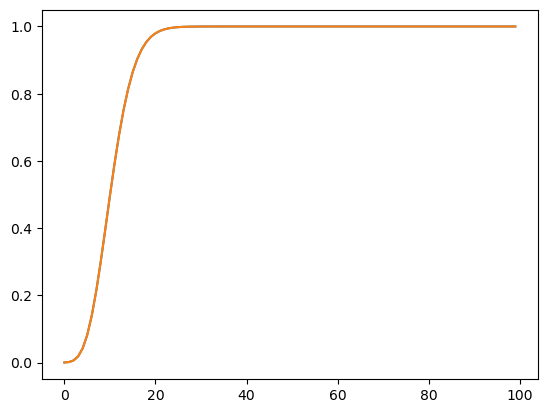

In [ ]:
p_s = dist.cat.logits.softmax(-1)
nb_r = dist.nb.total_count
nb_p = dist.nb.logits.sigmoid()

k = torch.arange(100, device=p_s.device)

import scipy

import matplotlib.pyplot as plt
scipy.special.betainc(nb_r.detach().cpu().numpy(), k.detach().cpu().numpy() + 1, nb_p.detach().cpu().numpy())



In [ ]:
torch.lgamma

<function torch._VariableFunctionsClass.lgamma>

In [ ]:
torch.special.bet

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'torch.special' from '/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/torch/special/__init__.py'>

In [ ]:
from utils.plot import test_sample_plots
from utils import get_exp_name, masking, env


In [ ]:
loss = 'ppo'; backbone = 'rnn'; weights = [0.7, 0.3]; seg_dist = 'cat_nb'; dataset = 'onetwo'; target_type = 'y'; predictor_type = 'predictor'; mask_type = 'seq'
exp_name = get_exp_name(loss, backbone, weights, seg_dist, dataset, target_type, predictor_type, mask_type)

Pr:pred_Da:onetwo_L:ppo_BacB:rnn_SegD:cat_nb_We:0.7,0.3_Tr:y_Ms:seq


In [10]:
import torch
checkpoints = torch.load(f'./checkpoints/{exp_name}/checkpoints.pth')

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-85bce55d4056>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

In [11]:
checkpoints['predictor_state']

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OrderedDict([('backbone.tcn.0.conv1.bias',
              tensor([ 0.0976,  0.2988, -0.1630, -0.0365,  0.0997, -0.1380,  0.1204, -0.2667,
                      -0.1274, -0.0754,  0.2569,  0.2162,  0.3301,  0.0028,  0.0172, -0.2701,
                      -0.2532,  0.2113, -0.0185,  0.0633, -0.3067,  0.2232, -0.0954,  0.0726,
                       0.1408,  0.3226,  0.2209, -0.2197,  0.1488,  0.3305,  0.0483, -0.1960,
                       0.2919, -0.1225, -0.2123,  0.1983, -0.0336, -0.1663, -0.1066,  0.2575,
                       0.1976, -0.0160, -0.2002,  0.0948, -0.0007,  0.1248,  0.1356, -0.0832,
                       0.0635,  0.0340,  0.3212,  0.0023, -0.0550, -0.0207, -0.2471, -0.2462,
                       0.1577, -0.0988,  0.0394,  0.0973,  0.0357,  0.1320,  0.0999, -0.2300,
                       0.0320, -0.2177,  0.3750, -0.0872,  0.1220, -0.0353,  0.2636, -0.2574,
                       0.2893, -0.0758,  0.2123,  0.0007,  0.0732, -0.2628,  0.0396,  0.3614,
                 

In [ ]:
import re
import matplotlib.pyplot as plt


import re
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tensordict import TensorDict
from tensordict.nn import TensorDictModule, InteractionType

from torchrl.data import BoundedTensorSpec
from torchrl.modules import ProbabilisticActor, ValueOperator


from dataloader import SeqComb
from models import Policy, Value, Predictor
from distributions import CategoricalToNegativeBinomial, CategoricalToCategorical, NegativeBinomialToNegativeBinomial
from utils import get_exp_name, masking, env
from rewards import Reward


def test_sample_plots(
    loss,
    backbone,
    weights,
    seg_dist,
    dataset,
    target_type,
    predictor_type,
    predictor_pretrain,
    mask_type,
):  
    device = 'cuda:4'
    d_in        = 1
    d_model     = 128
    seq_len     = 100
    d_out, average = SeqComb.get_num_classes(dataset)

    test_set = SeqComb.get_SeqComv(dataset, 'TEST')

    exp_name = get_exp_name(loss, backbone, weights, seg_dist, dataset, target_type, predictor_type, predictor_pretrain, mask_type)
    exp_dir = f'./checkpoints/{exp_name}'
    
    checkpoints = torch.load(f'{exp_dir}/checkpoints.pth')

    policy_module = Policy.init_policy_module(
        d_in = d_in,
        d_model = d_model,
        seq_len = seq_len,
        backbone = backbone,
        seg_dist = seg_dist
    )
    policy_module = policy_module.to(device)
    policy_module.load_state_dict(checkpoints['policy_state'])
    policy_module.eval()
    class_samples = {}
    for c in range(d_out):
        class_samples[c] = []

    for batch in test_set:
        x = batch['x']
        y = batch['y']
        if len(class_samples[y.item()]) < 20:
            class_samples[y.item()].append([x.squeeze(0), y])

        tot = 0
        for k, v in class_samples.items():
            tot += len(v)
        if tot == 20 * d_out:
            break
    

    blackbox_model = Predictor.PredictorNetwork(d_in=1, d_model=64, d_out=d_out, seq_len=seq_len, backbone='tcn')
    blackbox_model.load_state_dict(torch.load(f'./blackbox/best_{dataset}_tcn.pth')['model_state'])
    blackbox_model = blackbox_model.to(device)
    blackbox_model = blackbox_model.eval()

    if predictor_type == 'blackbox':
        predictor = blackbox_model
    elif predictor_type == 'predictor':
        predictor = Predictor.PredictorNetwork(d_in=d_in, d_model=d_model, d_out=d_out, seq_len=seq_len, backbone=backbone)
        predictor = predictor.to(device)
        predictor.load_state_dict(checkpoints['predictor_state'])
        predictor.eval()
    
    mask_fn = masking.MaskingFunction(mask_type)

    ce_reward_fn = partial(Reward.exp_minus_cross_entropy_reward, mask_fn=mask_fn, predictor=predictor)
    length_reward_fn = Reward.length_reward

    reward_fns = [ce_reward_fn, length_reward_fn]
    reward_fn = partial(Reward.compose_reward, reward_fns=reward_fns, weights=weights)


    n_cols = 5
    rows_per_class = 20 // n_cols  # 4
    n_rows = rows_per_class * d_out    # 클래스 2개

    fig = plt.figure(figsize=(20, 4 * n_rows))
    outer_gs = fig.add_gridspec(n_rows, n_cols) #, wspace=0.3, hspace=0.4)

    # fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
    for cls in range(d_out):
        for idx, (x_sample, y_sample) in enumerate(class_samples[cls]):
            row = cls * rows_per_class + idx // n_cols
            col = idx % n_cols

            inner_gs = outer_gs[row, col].subgridspec(
                2, 1, height_ratios=[3, 1], hspace=0.03
            )
            ax_top  = fig.add_subplot(inner_gs[0])
            ax_bot  = fig.add_subplot(inner_gs[1], sharex=ax_top)
            # ------------------------------------------------------
            x_tensor = x_sample.unsqueeze(0).to(device)  # [1, T, C]
            if target_type == 'blackbox':
                y_target = blackbox_model(x_tensor)
            elif target_type == 'y':
                y_target = y_sample.unsqueeze(0).to(device)

            with torch.no_grad():
                td = TensorDict(
                    {"x": x_tensor, 'y':y_target ,"curr_mask": torch.zeros_like(x_tensor, dtype=torch.bool)},
                    batch_size=(1,), device=device
                )
                env.step(td, policy_module, reward_fn, mode=True)

            x_masked = mask_fn(x_tensor, td["next", "curr_mask"])
        
            with torch.no_grad():
                if target_type == 'blackbox':
                    probs = blackbox_model(x_masked).softmax(-1)
                    prob_true = probs[0, cls].item()
                elif target_type == 'y':
                    prob_true = 1.

            x_np = x_sample.cpu().squeeze().numpy()
            x_masked = x_masked.squeeze().cpu().numpy()
            mask = td["next", "curr_mask"][0].cpu().squeeze().numpy()    # [T]
            

            ax_top.plot(x_np,     label="Original")
            ax_top.plot(x_masked, label="Masked")
            ax_top.set_title(f"Class {cls} Sample {idx+1}", fontsize=9)
            ax_top.tick_params(labelsize=7)
            if col == 0:
                ax_top.set_ylabel("Value", fontsize=8)

            # 마스크된 구간 강조 (axvspan)
            mi = mask.astype(int)
            d  = np.diff(mi)
            starts = np.where(d == 1)[0] + 1
            ends   = np.where(d == -1)[0] + 1
            if mask[0]:
                starts = np.r_[0, starts]
            if mask[-1]:
                ends = np.r_[ends, mask.size]
            for s, e in zip(starts, ends):
                ax_top.axvspan(s, e, alpha=0.25)

            ax_bot.imshow(mask[np.newaxis, :],
                aspect='auto', cmap='Greys',
                interpolation='nearest',
                extent=[0, len(mask)-1, 0, 1]
            )
            ax_bot.set_yticks([])
            ax_bot.set_xlim(0, len(mask)-1)
            if col == 0:
                ax_bot.set_ylabel("mask", fontsize=8)
            ax_bot.set_xlabel("t", fontsize=8)

    # 범례 한 번만 표시
    handles, labels = ax_top.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=9)
    fig.tight_layout()
    fig.suptitle("Test Samples: Original vs Masked (with 1-D Heat-map)", fontsize=16)
    fig.savefig("sample.png", dpi=200)
    plt.close() 

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pr:pred:100_Da:onetwo_Lo:ppo_Bc:tcn_Sd:cat_nb_We:0.7,0.3_Tg:y_Ms:seq


<ipython-input-11-d734bdcc5de2>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load(f'{exp_dir}/checkpoints.pth')
/home/hjkim/anaconda3/envs/torchrl/l

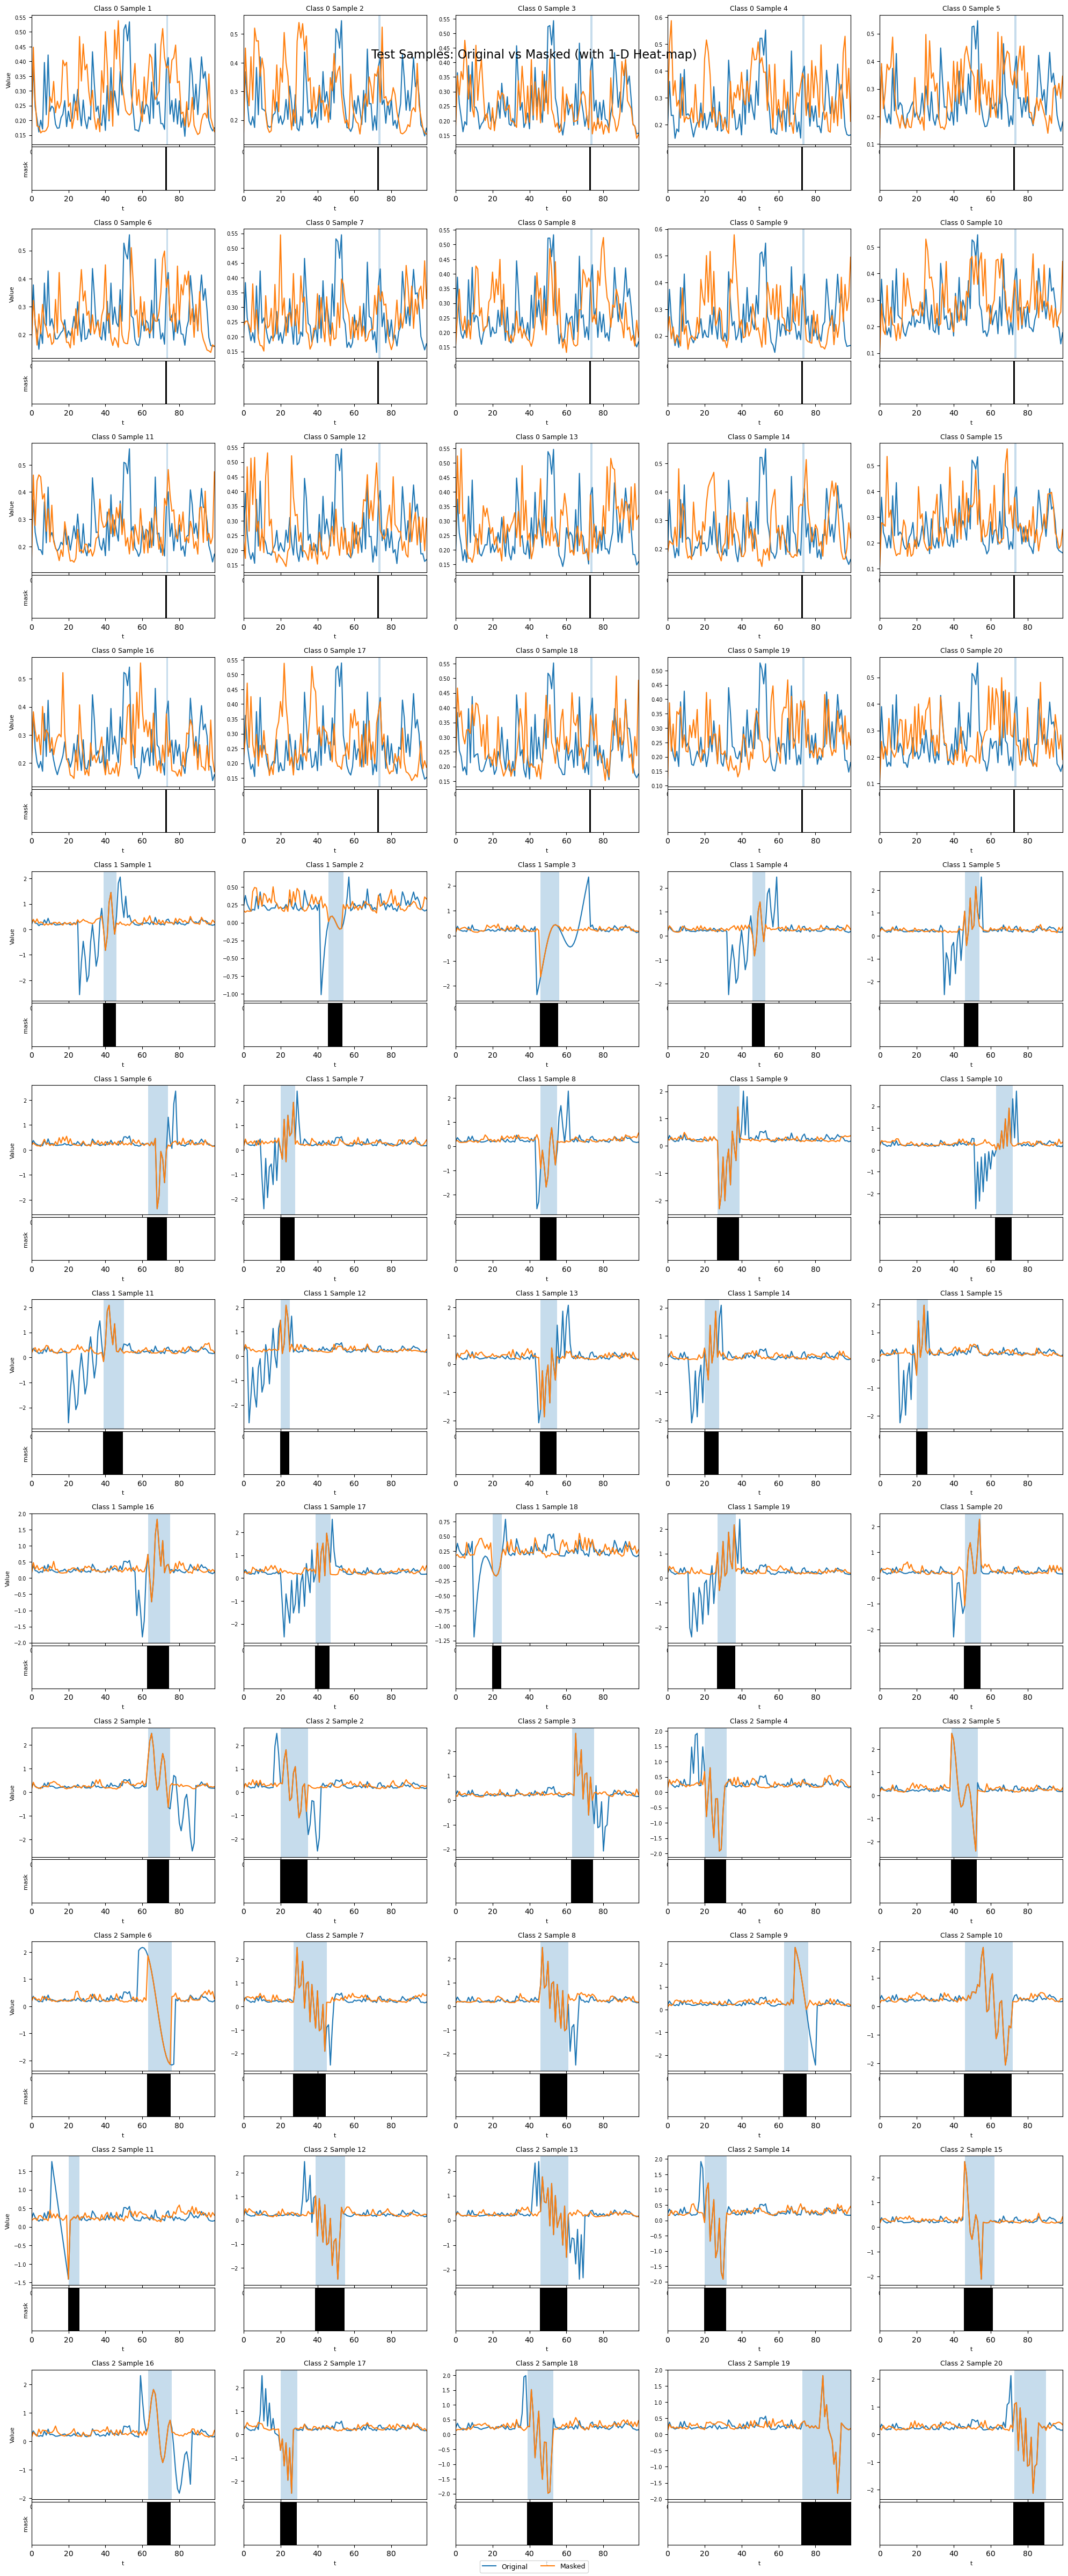

In [12]:
policy_module = test_sample_plots(
    loss='ppo',
    backbone='tcn',
    weights=[0.7, 0.3],
    seg_dist='cat_nb',
    dataset='onetwo',
    target_type='y',
    predictor_type='predictor',
    predictor_pretrain=100,
    mask_type='seq',
)

In [21]:
dist = policy_module.get_dist(td)


/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
cat = dist.cat
nb = dist.nb

In [30]:
start_p = cat.probs

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


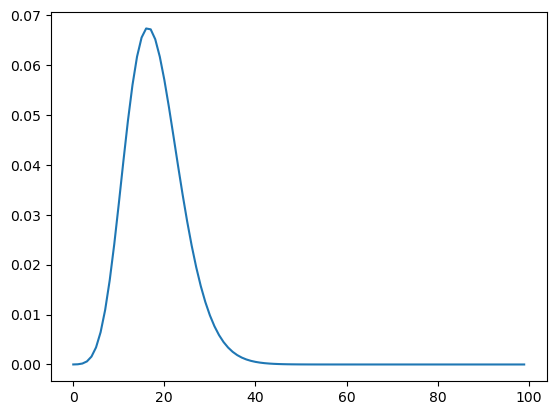

In [51]:
t = torch.arange(100, device='cuda:4')
nb_pmf = nb.log_prob(t).exp()

plt.plot(range(100), nb_pmf.detach().cpu().numpy())
plt.show()

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


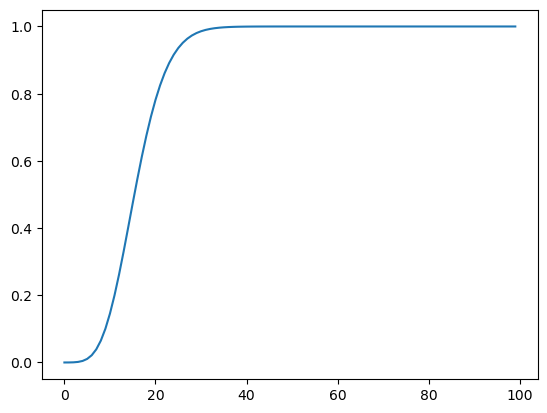

In [50]:
import scipy.special as S
cdf = S.betainc(nb.total_count.detach().cpu(), torch.arange(100)+1, nb.probs.detach().cpu())

plt.plot(range(100), cdf.numpy())
plt.show()

In [ ]:
start_p = dist.cat.probs
mask_probs = torch.zeros_like(start_p)
mask_probs[:, 0] = start_p[:, 0]
mask_probs[:, 1] = start_p[:, 1] + start_p[:, 0] * cdf[99]
mask_probs[:, 2] = start_p[:, 2] + start_p[:, 1] * cdf[99]

tensor([[3.9340e-06, 1.1824e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [106]:
nb.log_prob(torch.FloatTensor([0.]).to("cuda:4")).exp()

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([4.6287e-06], device='cuda:4', grad_fn=<ExpBackward0>)

In [ ]:

k_vals = torch.arange(100)
F_k = S.betainc(nb.total_count.detach().cpu(), k_vals.unsqueeze(0)+1, start_p.detach().cpu())
surv = torch.ones_like(F_k)
surv[:, 1:] = 1.0 - F_k[:, :-1]
start_p = start_p.cpu()
mask_probs = torch.zeros_like(start_p)
for s in range(100):
    mask_probs[:, s:] += start_p[:, s:s+1] * surv[:, :100-s]


In [108]:
self = dist

In [ ]:
start_p = self.cat.probs
total_count = self.nb.total_count
nb_probs = self.nb.probs
seq_len = 100

delta = torch.arange(seq_len, device=start_p.device).detach().cpu().unsqueeze(0)
cdf = S.betainc(total_count.detach().cpu(), delta+1, nb_probs.detach().cpu())
surv = 1. - cdf
start_p

torch.Size([1, 100])

In [141]:
from utils.plot import test_sample_plots

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


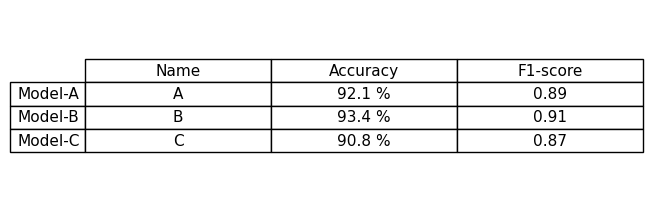

In [126]:
import matplotlib.pyplot as plt

# 예시 데이터
col_labels = ["Name", "Accuracy", "F1-score"]
row_labels = ["Model-A", "Model-B", "Model-C"]
table_vals = [
    ["A", "92.1 %", "0.89"],
    ["B", "93.4 %", "0.91"],
    ["C", "90.8 %", "0.87"],
]

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis("off")  # 축 숨기기

# 표 추가
table = ax.table(
    cellText=table_vals,
    colLabels=col_labels,
    rowLabels=row_labels,
    loc="center",
    cellLoc="center",
)

table.set_fontsize(11)
table.scale(1.2, 1.4)   # (가로, 세로) 크기 조정

plt.show()

In [1]:
start_p  = dist.cat.probs[0].detach().cpu().numpy()           # (T,)
T        = start_p.size

r        = float(dist.nb.total_count[0])
p        = float(dist.nb.probs[0])

max_delta = 99
k = torch.arange(max_delta + 1).to("cuda:4")
delta_pmf = dist.nb.log_prob(k).exp().detach().cpu().numpy()  # (K+1,)

mask_p   = mask_probs[0].cpu().numpy()               # (T,)

# --------- Figure & Axes ------------------------------------------
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(10, 8),
    sharex=False,
    constrained_layout=True
)

# 1) Categorical
ax0 = axes[0]
ax0.bar(range(T), start_p, color='tab:blue')
ax0.set_ylabel("P(start=s)")
ax0.set_title("Categorical: start position distribution")
ax0.set_xlim(-0.5, T - 0.5)

# 2) Negative-Binomial PMF
ax1 = axes[1]
ax1.bar(range(max_delta + 1), delta_pmf, color='tab:orange')
ax1.set_ylabel("P(Δ=d)")
ax1.set_title(f"Negative-Binomial PMF (r={r:.1f}, p={p:.2f})")
ax1.set_xlim(-0.5, max_delta + 0.5)

# 3) Marginal mask prob
# imshow expects 2-D; use (1, T) to draw a stripe
ax2 = axes[2]
im = ax2.imshow(
    mask_p[np.newaxis, :],
    aspect="auto",
    cmap='viridis',
    interpolation="nearest",
    extent=[0, T - 1, 0, 1]      # x-axis aligns with t
)
ax2.set_ylabel("P(mask_t = 1)")
ax2.set_xlabel("time-step t")
ax2.set_title("Expected mask (marginal)")
ax2.set_ylim(0, 1)
ax2.set_xlim(0, T - 1)
plt.show()

NameError: name 'dist' is not defined

In [1]:
import sys
sys.path.append("/home/hjkim/RL_TimeSegment")

import re
import matplotlib.pyplot as plt


import re
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import scipy.special as S

import torch
import torch.nn as nn
import torch.nn.functional as F

from tensordict import TensorDict
from tensordict.nn import TensorDictModule, InteractionType

from torchrl.data import BoundedTensorSpec
from torchrl.modules import ProbabilisticActor, ValueOperator


from dataloader import SeqComb
from models import Policy, Value, Predictor
from distributions import CategoricalToNegativeBinomial, CategoricalToCategorical, NegativeBinomialToNegativeBinomial
from utils import get_exp_name, masking, env
from rewards import Reward




def test_sample_plots(
    loss,
    backbone,
    weights,
    seg_dist,
    dataset,
    target_type,
    predictor_type,
    predictor_pretrain,
    mask_type,
):  
    device = 'cuda:4'
    d_in        = 1
    d_model     = 128
    seq_len     = 100
    d_out, average = SeqComb.get_num_classes(dataset)

    test_set = SeqComb.get_SeqComv(dataset, 'TEST')

    exp_name = get_exp_name(loss, backbone, weights, seg_dist, dataset, target_type, predictor_type, predictor_pretrain, mask_type)
    exp_dir = f'./checkpoints/{exp_name}'
    
    checkpoints = torch.load(f'{exp_dir}/checkpoints.pth')

    policy_module = Policy.init_policy_module(
        d_in = d_in,
        d_model = d_model,
        seq_len = seq_len,
        backbone = backbone,
        seg_dist = seg_dist
    )
    policy_module = policy_module.to(device)
    policy_module.load_state_dict(checkpoints['policy_state'])
    policy_module.eval()
    class_samples = {}
    for c in range(d_out):
        class_samples[c] = []

    for batch in test_set:
        x = batch['x']
        y = batch['y']
        if len(class_samples[y.item()]) < 20:
            class_samples[y.item()].append([x.squeeze(0), y])

        tot = 0
        for k, v in class_samples.items():
            tot += len(v)
        if tot == 20 * d_out:
            break
    

    blackbox_model = Predictor.PredictorNetwork(d_in=1, d_model=64, d_out=d_out, seq_len=seq_len, backbone='tcn')
    blackbox_model.load_state_dict(torch.load(f'./blackbox/best_{dataset}_tcn.pth')['model_state'])
    blackbox_model = blackbox_model.to(device)
    blackbox_model = blackbox_model.eval()

    if predictor_type == 'blackbox':
        predictor = blackbox_model
    elif predictor_type == 'predictor':
        predictor = Predictor.PredictorNetwork(d_in=d_in, d_model=d_model, d_out=d_out, seq_len=seq_len, backbone=backbone)
        predictor = predictor.to(device)
        predictor.load_state_dict(checkpoints['predictor_state'])
        predictor.eval()
    
    mask_fn = masking.MaskingFunction(mask_type)

    ce_reward_fn = partial(Reward.exp_minus_cross_entropy_reward, mask_fn=mask_fn, predictor=predictor)
    length_reward_fn = Reward.length_reward

    reward_fns = [ce_reward_fn, length_reward_fn]
    reward_fn = partial(Reward.compose_reward, reward_fns=reward_fns, weights=weights)


    n_cols = 5
    rows_per_class = 20 // n_cols  # 4
    n_rows = rows_per_class * d_out    # 클래스 2개

    fig = plt.figure(figsize=(20, 4 * n_rows))
    outer_gs = fig.add_gridspec(n_rows, n_cols) #, wspace=0.3, hspace=0.4)

    # fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
    for cls in range(d_out):
        for idx, (x_sample, y_sample) in enumerate(class_samples[cls]):
            row = cls * rows_per_class + idx // n_cols
            col = idx % n_cols

            inner_gs = outer_gs[row, col].subgridspec(
                4, 1, height_ratios=[2, 0.5, 0.5, 0.5], hspace=0.03
            )
            ax_top  = fig.add_subplot(inner_gs[0])
            ax_mask  = fig.add_subplot(inner_gs[1], sharex=ax_top)
            ax_start  = fig.add_subplot(inner_gs[2], sharex=ax_top)
            ax_end  = fig.add_subplot(inner_gs[3], sharex=ax_top)
            # ------------------------------------------------------
            x_tensor = x_sample.unsqueeze(0).to(device)  # [1, T, C]
            if target_type == 'blackbox':
                y_target = blackbox_model(x_tensor)
            elif target_type == 'y':
                y_target = y_sample.unsqueeze(0).to(device)

            with torch.no_grad():
                td = TensorDict(
                    {"x": x_tensor, 'y':y_target ,"curr_mask": torch.zeros_like(x_tensor, dtype=torch.bool)},
                    batch_size=(1,), device=device
                )
                dist = policy_module.get_dist(td)
                mask_probs = dist.calculate_marginal_mask().cpu().numpy()
                env.step(td, policy_module, reward_fn, mode=True)

            x_masked = mask_fn(x_tensor, td["next", "curr_mask"])
        
            with torch.no_grad():
                if target_type == 'blackbox':
                    probs = blackbox_model(x_masked).softmax(-1)
                    prob_true = probs[0, cls].item()
                elif target_type == 'y':
                    prob_true = 1.

            x_np = x_sample.cpu().squeeze().numpy()
            x_masked = x_masked.squeeze().cpu().numpy()
            mask = td["next", "curr_mask"][0].cpu().squeeze().numpy()    # [T]
            

            ax_top.plot(x_np,     label="Original")
            ax_top.plot(x_masked, label="Masked")
            ax_top.set_title(f"Class {cls} Sample {idx+1}", fontsize=9)
            ax_top.tick_params(labelsize=7)
            if col == 0:
                ax_top.set_ylabel("Value", fontsize=8)

            # 마스크된 구간 강조 (axvspan)
            mi = mask.astype(int)
            d  = np.diff(mi)
            starts = np.where(d == 1)[0] + 1
            ends   = np.where(d == -1)[0] + 1
            if mask[0]:
                starts = np.r_[0, starts]
            if mask[-1]:
                ends = np.r_[ends, mask.size]
            for s, e in zip(starts, ends):
                ax_top.axvspan(s, e, alpha=0.25)


            ax_mask.imshow(mask_probs.reshape(-1)[np.newaxis, :],
                aspect='auto', cmap='RdBu_r',
                interpolation='nearest',
                extent=[0, len(mask)-1, 0, 1]
            )
            ax_mask.set_yticks([])
            ax_mask.set_xlim(0, len(mask)-1)
            if col == 0:
                ax_mask.set_ylabel("mask", fontsize=8)
            ax_mask.set_xlabel("t", fontsize=8)

            if seg_dist == 'cat_cat':
                start_p = dist.cat_start.probs.detach().cpu().numpy().reshape(-1)
                ax_start.bar(range(seq_len), start_p, color='tab:blue', label='P(start=s)')
                ax_start.legend(fontsize=5)

                end_p = dist.end_logits.softmax(dim=-1).detach().cpu().numpy().reshape(-1)
                ax_end.bar(range(seq_len), end_p, color='tab:orange', label='P(end=e)')
                ax_end.legend(fontsize=5)

            elif seg_dist == 'cat_nb':
                start_p = dist.cat.probs.detach().cpu().numpy().reshape(-1)
                ax_start.bar(range(seq_len), start_p, color='tab:blue', label='P(start=s)')
                ax_start.legend(fontsize=5)

                end_p = dist.nb.log_prob(torch.arange(seq_len, device=dist.nb.probs.device)).exp().detach().cpu().numpy().reshape(-1)
                ax_end.bar(range(seq_len), end_p, color='tab:orange', label='P(Δ=d)')
                ax_end.legend(fontsize=5)
            
            elif seg_dist == 'nb_nb':
                start_p = dist.nb_start.log_prob(torch.arange(seq_len, device=dist.nb_start.probs.device)).exp().detach().cpu().numpy().reshape(-1)
                ax_start.bar(range(seq_len), start_p, color='tab:blue', label='P(Δ=s)')
                ax_start.legend(fontsize=5)

                end_p = dist.nb_end.log_prob(torch.arange(seq_len, device=dist.nb_end.probs.device)).exp().detach().cpu().numpy().reshape(-1)
                ax_end.bar(range(seq_len), end_p, color='tab:orange', label='P(Δ=d)')
                ax_end.legend(fontsize=5)

    # 범례 한 번만 표시
    handles, labels = ax_top.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=9)
    fig.tight_layout()
    fig.suptitle("Test Samples: Original vs Masked (with 1-D Heat-map)", fontsize=16)
    fig.savefig("sample.png", dpi=200)
    plt.close() 


# def test_sample_plots(
#     loss,
#     backbone,
#     weights,
#     seg_dist,
#     dataset,
#     target_type,
#     predictor_type,
#     predictor_pretrain,
#     mask_type,
# ):  
#     device = 'cuda:4'
#     d_in        = 1
#     d_model     = 128
#     seq_len     = 100
#     d_out, average = SeqComb.get_num_classes(dataset)

#     test_set = SeqComb.get_SeqComv(dataset, 'TEST')

#     exp_name = get_exp_name(loss, backbone, weights, seg_dist, dataset, target_type, predictor_type, predictor_pretrain, mask_type)
#     exp_dir = f'./checkpoints/{exp_name}'
    
#     checkpoints = torch.load(f'{exp_dir}/checkpoints.pth')

#     policy_module = Policy.init_policy_module(
#         d_in = d_in,
#         d_model = d_model,
#         seq_len = seq_len,
#         backbone = backbone,
#         seg_dist = seg_dist
#     )
#     policy_module = policy_module.to(device)
#     policy_module.load_state_dict(checkpoints['policy_state'])
#     policy_module.eval()
#     class_samples = {}
#     for c in range(d_out):
#         class_samples[c] = []

#     for batch in test_set:
#         x = batch['x']
#         y = batch['y']
#         if len(class_samples[y.item()]) < 20:
#             class_samples[y.item()].append([x.squeeze(0), y])

#         tot = 0
#         for k, v in class_samples.items():
#             tot += len(v)
#         if tot == 20 * d_out:
#             break
    

#     blackbox_model = Predictor.PredictorNetwork(d_in=1, d_model=64, d_out=d_out, seq_len=seq_len, backbone='tcn')
#     blackbox_model.load_state_dict(torch.load(f'./blackbox/best_{dataset}_tcn.pth')['model_state'])
#     blackbox_model = blackbox_model.to(device)
#     blackbox_model = blackbox_model.eval()

#     if predictor_type == 'blackbox':
#         predictor = blackbox_model
#     elif predictor_type == 'predictor':
#         predictor = Predictor.PredictorNetwork(d_in=d_in, d_model=d_model, d_out=d_out, seq_len=seq_len, backbone=backbone)
#         predictor = predictor.to(device)
#         predictor.load_state_dict(checkpoints['predictor_state'])
#         predictor.eval()
    
#     mask_fn = masking.MaskingFunction(mask_type)

#     ce_reward_fn = partial(Reward.exp_minus_cross_entropy_reward, mask_fn=mask_fn, predictor=predictor)
#     length_reward_fn = Reward.length_reward

#     reward_fns = [ce_reward_fn, length_reward_fn]
#     reward_fn = partial(Reward.compose_reward, reward_fns=reward_fns, weights=weights)


#     n_cols = 5
#     rows_per_class = 20 // n_cols  # 4
#     n_rows = rows_per_class * d_out    # 클래스 2개

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
#     for cls in range(d_out):
#         for idx, (x_sample, y_sample) in enumerate(class_samples[cls]):
#             row = cls * rows_per_class + idx // n_cols
#             col = idx % n_cols

#             x_tensor = x_sample.unsqueeze(0).to(device)  # [1, T, C]
#             if target_type == 'blackbox':
#                 y_target = blackbox_model(x_tensor)
#             elif target_type == 'y':
#                 y_target = y_sample.unsqueeze(0).to(device)

#             with torch.no_grad():
#                 td = TensorDict(
#                     {"x": x_tensor, 'y':y_target ,"curr_mask": torch.zeros_like(x_tensor, dtype=torch.bool)},
#                     batch_size=(1,), device=device
#                 )
#                 env.step(td, policy_module, reward_fn, mode=True)


#             x_masked = mask_fn(x_tensor, td["next", "curr_mask"])
        
#             with torch.no_grad():
#                 if target_type == 'blackbox':
#                     probs = blackbox_model(x_masked).softmax(-1)
#                     prob_true = probs[0, cls].item()
#                 elif target_type == 'y':
#                     prob_true = 1.

#             x_np = x_sample.cpu().squeeze().numpy()
#             x_masked = x_masked.squeeze().cpu().numpy()
#             mask = td["next", "curr_mask"][0].cpu().squeeze().numpy()    # [T]
            

#             ax = axes[row][col]
#             ax.plot(x_np,    label="Original")
#             ax.plot(x_masked, label="Masked")
#             ax.text(0.95, 0.95, f"P(class={cls})={prob_true:.2f}",
#                     ha='right', va='top', transform=ax.transAxes,
#                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

#             # 마스크된 구간 강조 (axvspan)
#             mi = mask.astype(int)
#             d = np.diff(mi)
#             starts = np.where(d == 1)[0] + 1
#             ends   = np.where(d == -1)[0] + 1
#             if mask[0]:
#                 starts = np.r_[0, starts]
#             if mask[-1]:
#                 ends = np.r_[ends, mask.size]
#             for s, e in zip(starts, ends):
#                 ax.axvspan(s, e, alpha=0.3)

#             ax.set_title(f"Class {cls} Sample {idx+1}")
#             if col == 0:
#                 ax.set_ylabel("Value")

#     # 범례 한 번만 표시
#     axes[0][0].legend(loc="lower right")
#     fig.suptitle("Test Samples: Original vs Masked", fontsize=16)
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(f"{exp_dir}/sample.png")
#     plt.close()

    

def result_plots(
    loss,
    backbone,
    weights,
    seg_dist,
    dataset,
    target_type,
    predictor_type,
    predictor_pretrain,
    mask_type,
):
    exp_name = get_exp_name(loss, backbone, weights, seg_dist, dataset, target_type, predictor_type, predictor_pretrain, mask_type)
    exp_dir = f'./checkpoints/{exp_name}'
    
    # checkpoint = torch.load(f"{exp_dir}/checkpoints.pth")
    history = torch.load(f"{exp_dir}/history.pth")

    avg_lengths = history['valid_length']
    avg_rewards = history['valid_reward']
    masked_accs = history['masked_acc']
    masked_f1s = history['masked_f1']
    epochs = list(range(1, len(avg_rewards)+1))

    best_idx = avg_rewards.index(max(avg_rewards))
    best_epoch = best_idx+1

    fig, axs = plt.subplots(4, 1, figsize=(8, 14), sharex=True)

    # Avg Length
    axs[0].plot(epochs, avg_lengths)
    axs[0].set_ylabel('Avg Length')
    axs[0].set_title('Validation Avg Length')
    axs[0].plot(best_epoch, avg_lengths[best_idx], 'ro')
    axs[0].annotate(f'Length {avg_lengths[best_idx]:.2f}',
                    xy=(best_epoch, avg_lengths[best_idx]),
                    xytext=(best_epoch, avg_lengths[best_idx]*1.05),
                    arrowprops=dict(arrowstyle='->'))

    # Avg Reward
    axs[1].plot(epochs, avg_rewards)
    axs[1].set_ylabel('Avg Reward')
    axs[1].set_title('Validation Avg Reward')
    axs[1].plot(best_epoch, avg_rewards[best_idx], 'ro')
    axs[1].annotate(f'Reward {avg_rewards[best_idx]:.2f}',
                    xy=(best_epoch, avg_rewards[best_idx]),
                    xytext=(best_epoch, avg_rewards[best_idx]*1.05),
                    arrowprops=dict(arrowstyle='->'))

    # Masked Accuracy
    axs[2].plot(epochs, masked_accs)
    axs[2].set_ylabel('Masked Acc')
    axs[2].set_title('Validation Masked Accuracy')
    axs[2].plot(best_epoch, masked_accs[best_idx], 'ro')
    axs[2].annotate(f'Acc {masked_accs[best_idx]:.2f}',
                    xy=(best_epoch, masked_accs[best_idx]),
                    xytext=(best_epoch, masked_accs[best_idx]+0.02),
                    arrowprops=dict(arrowstyle='->'))

    # Masked F1
    axs[3].plot(epochs, masked_f1s)
    axs[3].set_xlabel('Epoch')
    axs[3].set_ylabel('Masked F1')
    axs[3].set_title('Validation Masked F1 Score')
    axs[3].plot(best_epoch, masked_f1s[best_idx], 'ro')
    axs[3].annotate(f'F1 {masked_f1s[best_idx]:.2f}',
                    xy=(best_epoch, masked_f1s[best_idx]),
                    xytext=(best_epoch, masked_f1s[best_idx]+0.02),
                    arrowprops=dict(arrowstyle='->'))

    fig.tight_layout()
    plt.savefig(f'{exp_dir}/result_plots.png')
    plt.close()

In [2]:
test_sample_plots(
    loss='ppo',
    backbone='tcn',
    weights=[0.7, 0.3],
    seg_dist='nb_nb',
    dataset='onetwo',
    target_type='y',
    predictor_type='predictor',
    predictor_pretrain=100,
    mask_type='seq',
)

/home/hjkim/anaconda3/envs/torchrl/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-1-34f5cf6773ea>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Pr:pred:100_Da:onetwo_Lo:ppo_Bc:tcn_Sd:nb_nb_We:0.7,0.3_Tg:y_Ms:seq


<ipython-input-1-34f5cf6773ea>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blackbox_model.load_state_dict(torch.load(f'./blackbox/best_{dataset}_tcn.pth')['model_state